# **Human Gym Pose Detection**
**by Neural Network Ninjas (COMP9444)**

z5444643 Vishesh Malik

z5012904 Arifah binti Anwar Fadzil

z5465111 Sathwik Bharadwaj Udupi

z5447832 Devarshi Prakashbhai Patel

z5435266 Bhuvan Tulani

# **Section 1: Introduction, Motivation and/or Problem Statement :**

As a team of gym and fitness enthusiast, we recognized the potential of utilizing computer vision and neural network to count the repetition for a particular fitness activity in gym. Counting exercise repetition is one of the important metric people use to track the improvement of strength and metabolism. We then proceed to research on the most common exercises that people do in gym and look for the dataset to test our system. Our innovative project can replace manual human counter and allow the people to focus on his breathing and posture during exercise. This project could then be further used many other situations including physiotherapy and rehabilitation session.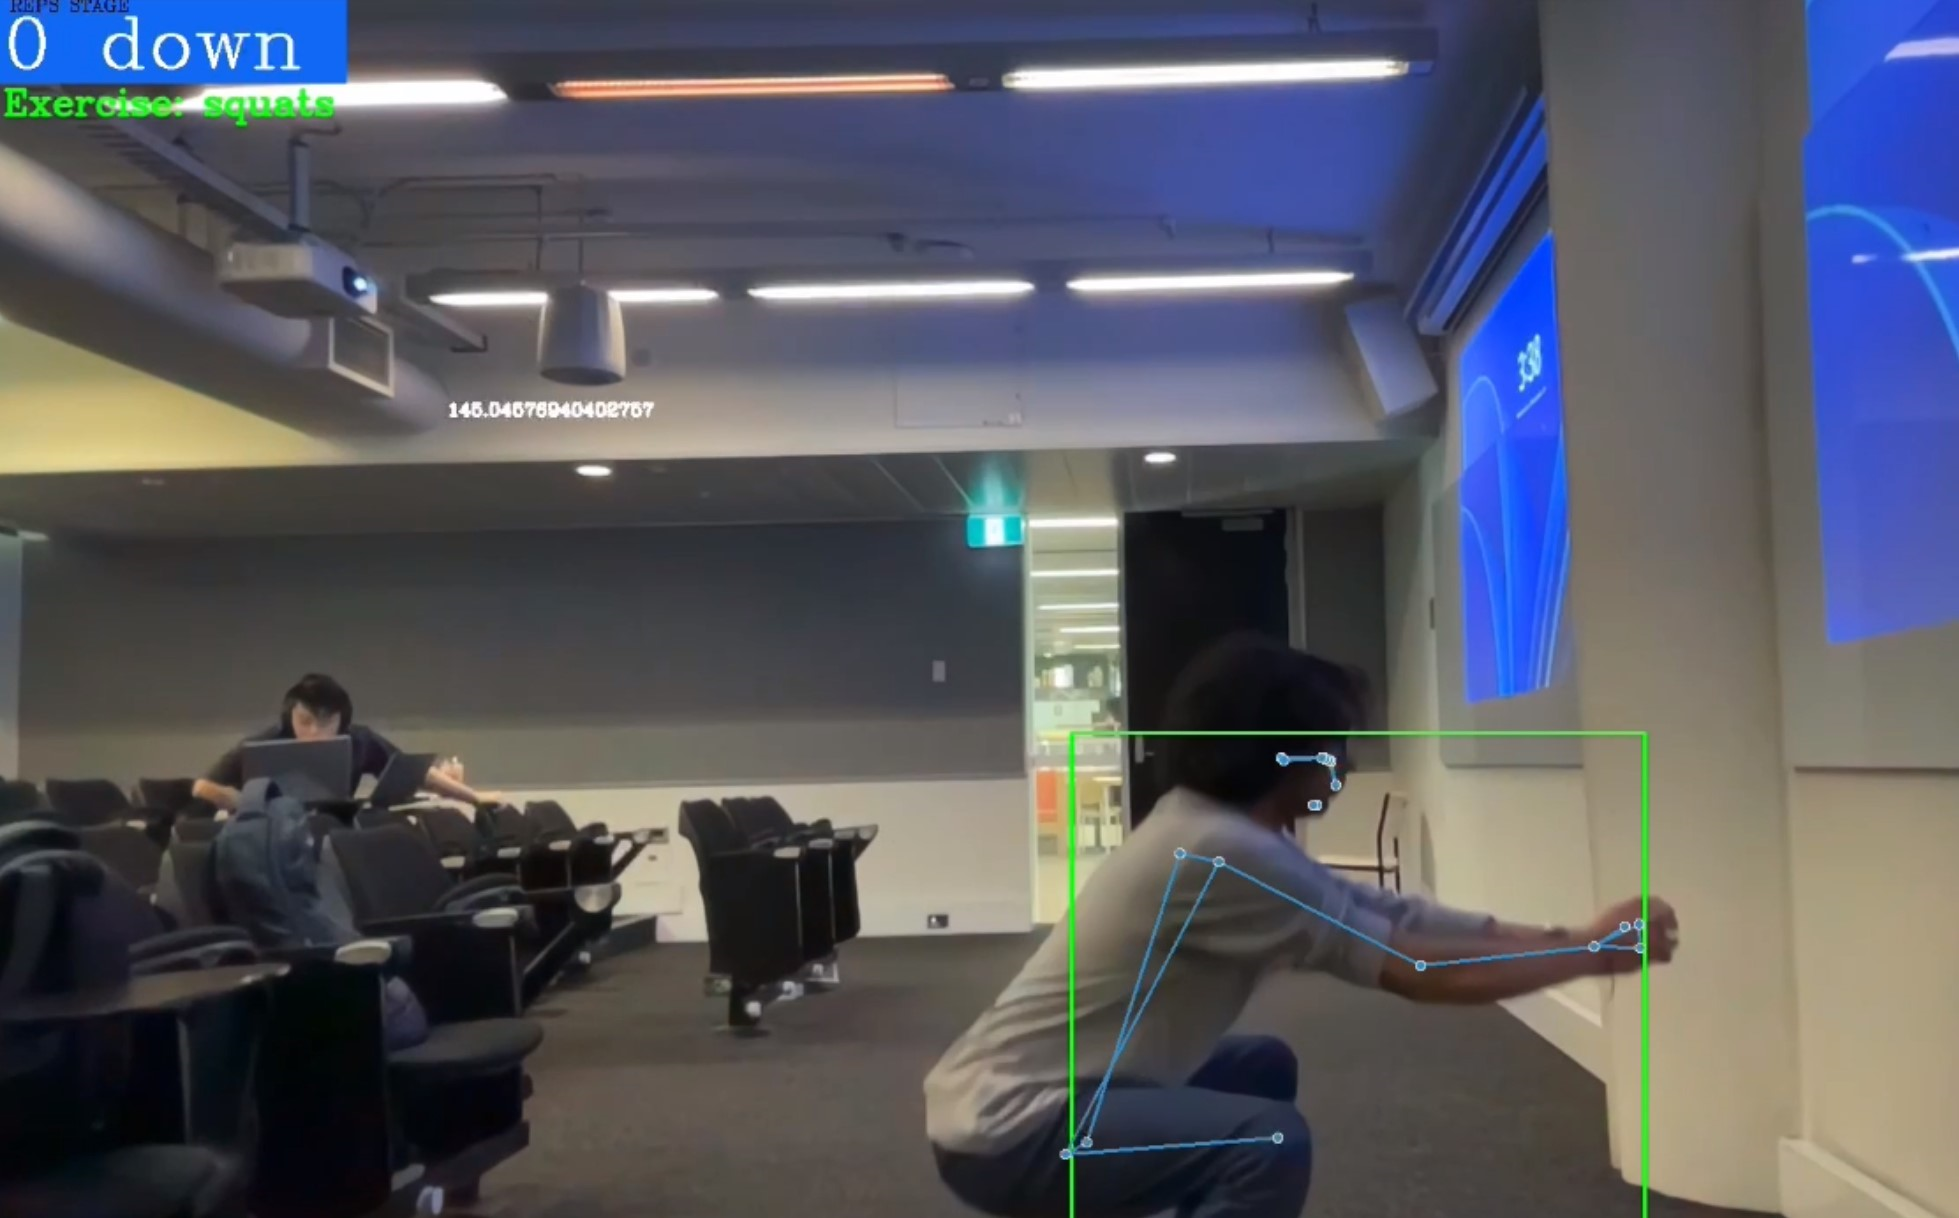


# **Section 2: Data sources:**

We are using the dataset we obtained from this InfiniteRep website. (https://paperswithcode.com/dataset/infiniterep)
There are 10 exercises provided with 100 videos &json file in each exercise.
We however are only using 3 exercises for this project which are the biceps curls, squats and overheadpress. In the json file, it has information for each frame that includes bounding box information, keypoints information and skeleton information. From the json file given,  we then created 3 videos from 1 input videos as part of our preprocessing to improve the robustness.​

Some of the excellent features of the data are:
- There are 7 different indoor scenes.
- There are a wide variety of people with different skin colour, body shape and clothing.
-The lighting conditions are diverse.
- The angles where the people doing exercise are different for each videos.

# **Section 3: Exploratory Analysis of Data:**

**Number of classes:**

In this project, we are only looking into 3 types of exercise, which are squats, biceps curls and overhead press. At the start of the project, we tried to incorporate all 10 types of exercise as we are hoping to implement this system in real gym condition and possibly during physiotherapy session. This however is not successful as we are facing a lot of RAM issue. We then decided to just proceed with 3 most common exercises people usually do in gym.

**Preprocessing of data:**

- Initially, we are only using the video as our training and testing input. The issue we found with these limited inputs are that the accuracy we obtained are below 50%. Upon research, we found that this is because the of the people background interfering with the recognition process.
To improve with the accuracy, we proceed with the data preprocessing. We extracted the data from json file and plotted the skeleton, bounding box and keypoints onto the videos input. As we are now increasing the amount of data input with more information, our model is more robust to changes and there is a big improvement on the accuracy of this preprocessing.

**Challenging aspects:**

1. Insufficient RAM and random crashes

Because we are dealing with huge amount of dataset in google colab, we are having issues with limited RAM and random crash when running our model. Even after purchasing extra RAM and better GPU under Google Colab Pro+, the improvement is small, but it still fails to accommodate our whole project that is to test on 10 different exercises.
Due to the time constraint, we then decided to just proceed with 3 types of most common exercises in gym and focus on improvement the best model for these exercises.

2. Dataset camera angle

One of the issues we observed with our accuracy values are that they are quite instable. Upon research and tutor’s input, we found out that this could be due to inconsistent angle of the camera when recording. Although many methods have been tried to improve the accuracy, the prediction our model give is lower than what we hope to achieve. Due to the time constraint, we are unable to prepare our own dataset and fixing the angle at a certain height and look angle. This makes it hard for us to achieve high accuracy as in recent similar project publication like in Human Pose Estimation for Fitness Exercise Movement Correction where all the angles are set and fix. (https://ieeexplore.ieee.org/document/9888451)

3. Real time tracker lagging

Due to the high computational cost for our project, we have also been facing with a lot of latency issue when running the real time tracker. This sometimes cause confusion for us when the counter is having a delay in updating to the correct number when analysing the webcam input.

4. Time constraint to fine tune and improvise the model

When running our code in Colab Pro+, we have been facing a lot of RAM warning and random crashes due to how large our dataset is. A lot of time has been spent just to solve these random crashes issue. To ensure the deliverable, we have improvised the model we found through here:
-    Data input and json processing: (https://paperswithcode.com/dataset/infiniterep)
-    LRCN & convLSTM model: (https://bleedaiacademy.com/human-activity-recognition-using-tensorflow-cnn-lstm/ )
-    YOLO to draw bounding box: (https://dipankarmedh1.medium.com/real-time-object-detection-with-yolo-and-webcam-enhancing-your-computer-vision-skills-861b97c78993)

We will discuss in detail the changes we made in the related section.






# **Section 4: Models and/or Methods :**

**Model selection:** For classification, we decided to compare between LRCN, LSTM and 3D CNN. The reason for this is because from this study we found (https://bleedaiacademy.com/human-activity-recognition-using-tensorflow-cnn-lstm/ ), the author manage to improve his result accuracy when combining both LSTM and CNN and build LRCN model. The author of this study is however using a different dataset from us where he is training on activities like taichi, dog walking, guitar playing etc.

**Improvisation we made:**
From the dataset we downloaded, we were also provided with simple starter code specifying how the json file could be extracted. We loop through all the files and videos we need and output the new video with key points, skeletons, and bounding boxes on the videos for training and testing.
To improve the code readability, we put this into 3 separate functions.
We also change the sequence length to a smaller value to reduce the computational cost. We remove the extra information that we don’t need like the camera angle when creating the dataset to reduce the running time.
When creating the model, we tried with different activation function on the dense layer as we are only getting very low accuracy at first. We thought the issue is because of the vanishing gradient but this seems not to be the issue here as changing the dense layer activation function show worse result. We also try with batch normalization together with increasing layers for each CONV2D, but the accuracy seems to be even worse. Upon trial and error, we found out that reducing the dropout layer to 0.2 give better performance than initial values that the author use. We also change the number of CONV2D layers and the number of neurons we added to LSTM layer.



### **Section 4.0 Videos Importing and Preprocessing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/COMP9444_TEST/Trial_JSON

/content/drive/MyDrive/COMP9444_TEST/Trial_JSON


### **Importing Libraries and setting up parameters**

In [3]:
import os
import cv2
import json
import glob
import numpy as np
import pandas as pd
import math
import random
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import deque
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from moviepy.editor import *
from IPython.display import *
!pip install ultralytics
from ultralytics import YOLO
from matplotlib import pyplot

img_height = 128
img_width = 128
frame = 20

seed_constant = 0
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)
random.seed(seed_constant)

exercise_types = os.listdir("/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/input/train_test")
print(exercise_types)

['squats', 'curls', 'overheadpress']


### **Preprocessing:**

The dataset is equipped with the json files for each videos and the json file contains the coordinates required to create bounding box, keypoints and skeleton.
We are parsing this json file along with the video and adding bounding box and getting a video with bounding box, like wise we do the same thing for the keypoints as well as skeleton.
By this we are increasing the dataset by creating 3 videos per video.


In [4]:
def boundbox(coco,images,out):
  for img, img_data in zip(images, coco.imgs.values()):
    image = img.copy()
    image_id = img_data["id"]
    annotation_id = coco.getAnnIds(imgIds=image_id)
    annotation = coco.loadAnns(annotation_id)
    for k in annotation:
        x,y,w,h = tuple(np.array(k["bbox"]).astype(int))
        cv2.rectangle(image, (x,y), (x+w, y+h), color=(255,255,255), thickness=2)
    out.write(image)
  out.release()

In [5]:
def keypoints(coco,images,out):
  for img, img_data in zip(images, coco.imgs.values()):
    image = img.copy()
    image_id = img_data["id"]
    annotation_id = coco.getAnnIds(imgIds=image_id)
    annotation = coco.loadAnns(annotation_id)
    for j in annotation:
        if "armature_keypoints" not in j:
            continue
        keypoints = j["armature_keypoints"]
        for keypoint_name, keypoint_info in keypoints.items():
            x, y = keypoint_info["x"], keypoint_info["y"]
            cv2.circle(image, (x, y), radius=2, color=(255,255,255), thickness=-1)
    out.write(image)
  out.release()

In [6]:
def skeleton(coco,images,keypoints_data,out):
  for img, img_data in zip(images, coco.imgs.values()):
    image = img.copy()
    image_id = img_data["id"]
    annotation_id = coco.getAnnIds(imgIds=image_id)
    annotation = coco.loadAnns(annotation_id)
    for j in annotation:

        if "armature_keypoints" not in j:
            continue
        keypoints = j["armature_keypoints"]
        for parent, child in keypoints_data:
            x0 = keypoints[parent]["x"]
            y0 = keypoints[parent]["y"]
            x1 = keypoints[child]["x"]
            y1 = keypoints[child]["y"]
            cv2.line(image, (x0, y0), (x1,y1), color=(255,255,255), thickness=2)
    out.write(image)
  out.release()

In [7]:
def preprocess(exercise_types):
  for i in exercise_types:
    json_paths = sorted(glob.glob(os.path.join(f'/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/input/train_test/{i}', "*.json")))
    #print(json_paths)
    metadata = []
    for json_path in json_paths:
        coco = COCO(json_path)
        metadata.append({
            "video_number": coco.dataset["info"]["video_number"]
        })
    video_info = pd.DataFrame(metadata)
    # print(video_info)

    keypoints_data = json.load(open('/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/armature/armature_connections.json','r'))
    x = video_info.iloc[:,0]

    output_path = f'./output/{i}'
    os.makedirs(output_path, exist_ok=True)
    for video_number in x:
      video_path = os.path.join(f'/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/input/train_test/{i}', f"{video_number:06d}.mp4")
      json_path = os.path.join(f'/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/input/train_test/{i}', f"{video_number:06d}.json")

      coco = COCO(json_path)
      cap = cv2.VideoCapture(video_path)

      frames = int(cap.get(cv2.CAP_PROP_FPS))
      images = []

      while cap.isOpened():
          ret, img = cap.read()
          if not ret:
              break
          images.append(img)
      images = np.array(images)
      bbpath = os.path.join(output_path, "bbox"+str(video_number)+".mp4")
      #print(bbpath)

      fourcc = cv2.VideoWriter_fourcc(*"mp4v")
      dimension = (224,224)
      out = cv2.VideoWriter(bbpath, fourcc, frames, dimension)
      boundbox(coco,images,out)

      keypoint = os.path.join(output_path, "keypoints"+str(video_number)+".mp4")
      out = cv2.VideoWriter(keypoint, fourcc, frames, dimension)
      keypoints(coco,images,out)

      skel_path = os.path.join(output_path, "skeleton"+str(video_number)+".mp4")
      out = cv2.VideoWriter(skel_path, fourcc, frames, dimension)
      skeleton(coco,images,keypoints_data,out)

Running the preprocess function

In [8]:
preprocess(exercise_types)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
load

In [9]:
dataset_path = "/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/output"
all_classes = exercise_types
print(all_classes)
#['squats', 'curls', 'overheadpress']

['squats', 'curls', 'overheadpress']


Extracting frames information and resizing and normalizing frames and creating feature dataset

Reference: https://bleedaiacademy.com/human-activity-recognition-using-tensorflow-cnn-lstm/

In [10]:
def extract_frames(video_path):
  frame = 20
  frames = []
  capture = cv2.VideoCapture(video_path)
  count_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_step = int(count_frames/frame)
  skip_frame = max(skip_step, 1)
  for i in range(frame):
    capture.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frame)
    success, frame = capture.read()
    if not success:
        break
    size_image =(img_height, img_width)
    resize_f = cv2.resize(frame, size_image)
    norm_f = resize_f / 255
    frames.append(norm_f)
  capture.release()
  return frames

We are creating features dataset here.
Reference: https://bleedaiacademy.com/human-activity-recognition-using-tensorflow-cnn-lstm/


In [18]:
def features_creation():
    features = []
    labels = []
    vids = []

    for i, j in enumerate(all_classes):
        files = os.listdir(os.path.join(dataset_path, j))
        for file in files:
            video_file_path = os.path.join(dataset_path, j, file)
            frames = extract_frames(video_file_path)
            if len(frames) == frame:
                features.append(frames)
                labels.append(i)
                vids.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, vids

In [19]:
features, labels, file_paths = features_creation()

In [20]:
print(features)

[[[[[   0.066667    0.062745      0.2549]
    [   0.066667    0.062745      0.2549]
    [   0.066667    0.062745      0.2549]
    ...
    [    0.18431         0.2     0.27843]
    [     0.3098     0.32941         0.4]
    [    0.39608     0.41569     0.48627]]

   [[   0.066667    0.062745      0.2549]
    [   0.066667    0.062745      0.2549]
    [   0.066667    0.062745      0.2549]
    ...
    [    0.36471     0.38039      0.4549]
    [    0.49412     0.50588     0.59608]
    [    0.25098     0.25882     0.36863]]

   [[   0.066667    0.062745      0.2549]
    [   0.066667    0.062745      0.2549]
    [   0.066667    0.062745      0.2549]
    ...
    [    0.46667     0.48235     0.56078]
    [    0.13725      0.1451      0.2549]
    [   0.011765    0.011765      0.1451]]

   ...

   [[     0.1451     0.23922     0.33333]
    [    0.15294     0.24706     0.34118]
    [    0.16471     0.25882     0.35294]
    ...
    [    0.34902     0.37647     0.47843]
    [    0.23529     0.24314  

### **One hot encoding the labels**

In [21]:
onehot_labels = to_categorical(labels)

### **Splitting the dataset for training and testing**

In [22]:
testsize = 0.1
train_res, test_res, train_label, test_label = train_test_split(features, onehot_labels, test_size = testsize, shuffle = True, random_state = seed_constant)


### **Section 4.1 : LRCN Model**
We have first Initialized Sequential Model and we have added layers one by one in a sequential manner.

It is followed by TimeDistributed Convolutional layer with ReLu activation.

The TimeDistributed Wrapper allows the application of a layer to each frame of the input video.
The Conv2d then detects the pattern present in each input frames.

This layer is then followed by Timedistributed MaxPooling layer, This reduces the spatial dimensions of the convolved features

It is then followed by Time distributed Dropout layer, this helps in preventing overfitting.

These layers are followed by another 3 TimeDistrubuted Convolutional layer with relu activation each followed by Timedistributed Maxpooling and Dropout layer respectively.

The output from the last dropout layer is flattened and fed as an input to the LSTM, it has 64 units and each units capture the patterns and information present in sequence of video frames

The final layer is fully connected dense layer with softmax activation function which gives output probabilities for each class.


Reference to build LRCN model: https://bleedaiacademy.com/human-activity-recognition-using-tensorflow-cnn-lstm/


In [23]:
def create_LRCN_model():
    LRCN_arch = Sequential()
    num = 64
    drop = 0.2
    input = (frame, img_height, img_width, 3)
    LRCN_arch.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),input_shape = input))
    LRCN_arch.add(TimeDistributed(MaxPooling2D((4, 4))))
    LRCN_arch.add(TimeDistributed(Dropout(drop)))

    LRCN_arch.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    LRCN_arch.add(TimeDistributed(MaxPooling2D((4, 4))))
    LRCN_arch.add(TimeDistributed(Dropout(drop)))

    for i in range (2):
      LRCN_arch.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
      LRCN_arch.add(TimeDistributed(MaxPooling2D((2, 2))))
      LRCN_arch.add(TimeDistributed(Dropout(drop)))

    LRCN_arch.add(TimeDistributed(Flatten()))
    LRCN_arch.add(LSTM(num))
    # LRCN_arch.add(Dense(len(all_classes), activation = 'relu'))
    LRCN_arch.add(Dense(len(all_classes), activation = 'softmax'))
    LRCN_arch.summary()
    return LRCN_arch



This is one of the fail LRCN model we have that give around 40% accuracy. We added the batch normalization following the founding from literature review we made.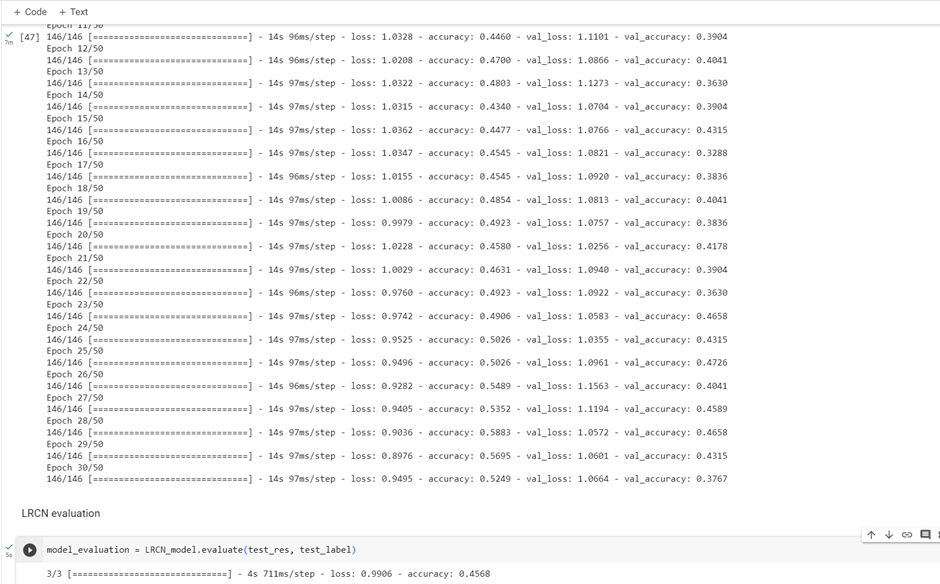

In [24]:

# def create_LRCN_model():
#     LRCN_arch = Sequential()
#     num = 64
#     drop = 0.25
#     input = (frame, img_height, img_width, 3)
#     LRCN_arch.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'),input_shape = input))
#     LRCN_arch.add(TimeDistributed(BatchNormalization()))
#     LRCN_arch.add(TimeDistributed(MaxPooling2D((2, 2))))
#     LRCN_arch.add(TimeDistributed(Dropout(drop)))

#     LRCN_arch.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
#     LRCN_arch.add(TimeDistributed(BatchNormalization()))
#     LRCN_arch.add(TimeDistributed(MaxPooling2D((2, 2))))
#     LRCN_arch.add(TimeDistributed(Dropout(drop)))

#     LRCN_arch.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
#     LRCN_arch.add(TimeDistributed(BatchNormalization()))
#     LRCN_arch.add(TimeDistributed(MaxPooling2D((2, 2))))
#     LRCN_arch.add(TimeDistributed(Dropout(drop)))


#     # for i in range (2):
#     #   LRCN_arch.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
#     #   LRCN_arch.add(TimeDistributed(MaxPooling2D((2, 2))))
#     #   LRCN_arch.add(TimeDistributed(Dropout(drop)))

#     LRCN_arch.add(TimeDistributed(Flatten()))
#     LRCN_arch.add(LSTM(128,return_sequences = True))
#     LRCN_arch.add(LSTM((64)))

#     LRCN_arch.add(Dense(64, activation = 'relu'))
#     LRCN_arch.add((Dropout(0.5)))



#     LRCN_arch.add(Dense(len(all_classes), activation = 'softmax'))
#     LRCN_arch.summary()
#     return LRCN_arch

Here we are creating the LRCN model and printing out the sequential model.

In [25]:
exercise_types = os.listdir("/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/input/train_test")
# print(exercise_types)
all_classes = exercise_types
# print(all_classes)
LRCN_model = create_LRCN_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 128, 128, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 32, 32, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 32, 32, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 32, 32, 64)    9280      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 8, 8, 64)      0

###**Compiling the Model**
This is the parameters for we use for LRCN model. We considered 'Adam' and 'SGD' for the optimizer but the 'Adam' gives the best result. 'Adam' is aso known for its efficiency and adaptibility. We are also using Early Stopping to avoid overfitting. Categorical crossentropy is used because it is a suitable choice for multi class classification.

We are using early callback function which monitor val_loss and stops the training when there is no improvement in val_loss for 10 epochs.

In [26]:
opt = 'Adam' # SGD
pat = 10
loss_type = 'categorical_crossentropy'
callback = EarlyStopping(monitor = 'val_loss', mode = 'min', restore_best_weights = True,  patience = pat )
LRCN_model.compile(loss = loss_type, optimizer = opt , metrics = ["accuracy"])

### **Training the LRCN Model**

The LRCN model is trained for 50 Epochs with batch size equals to 4. We also set the early stopping to prevent overfitting.

In [27]:
batchsize = 4 #32
valsplit = 0.2
ep = 50
LRCN_model_train = LRCN_model.fit(x = train_res, y = train_label, epochs = ep , batch_size = batchsize , shuffle = True, validation_split = valsplit, callbacks = [callback])

Epoch 1/50
146/146 [==============================] - 13s 41ms/step - loss: 1.0245 - accuracy: 0.4425 - val_loss: 0.8265 - val_accuracy: 0.6644
Epoch 2/50
146/146 [==============================] - 3s 24ms/step - loss: 0.4889 - accuracy: 0.7822 - val_loss: 0.5810 - val_accuracy: 0.7808
Epoch 3/50
146/146 [==============================] - 4s 24ms/step - loss: 0.2696 - accuracy: 0.8919 - val_loss: 0.1879 - val_accuracy: 0.9315
Epoch 4/50
146/146 [==============================] - 4s 24ms/step - loss: 0.1203 - accuracy: 0.9571 - val_loss: 0.1243 - val_accuracy: 0.9521
Epoch 5/50
146/146 [==============================] - 4s 24ms/step - loss: 0.1026 - accuracy: 0.9623 - val_loss: 0.1080 - val_accuracy: 0.9726
Epoch 6/50
146/146 [==============================] - 3s 24ms/step - loss: 0.0739 - accuracy: 0.9691 - val_loss: 0.0887 - val_accuracy: 0.9795
Epoch 7/50
146/146 [==============================] - 3s 24ms/step - loss: 0.0380 - accuracy: 0.9914 - val_loss: 0.0950 - val_accuracy: 0.979

The below is the LRCN evaluation we got. The accuracy is about 100%. (Note that in the presentation we did on Friday, we are only able to achieve an accuarcy of around 97%. We make some changes to the code and has managed to have slighly higher improvement. However even with this high of accuracy, the model stil make some prediction errors.)

In [28]:
model_evaluation = LRCN_model.evaluate(test_res, test_label)

3/3 [==============================] - 1s 213ms/step - loss: 0.0086 - accuracy: 1.0000


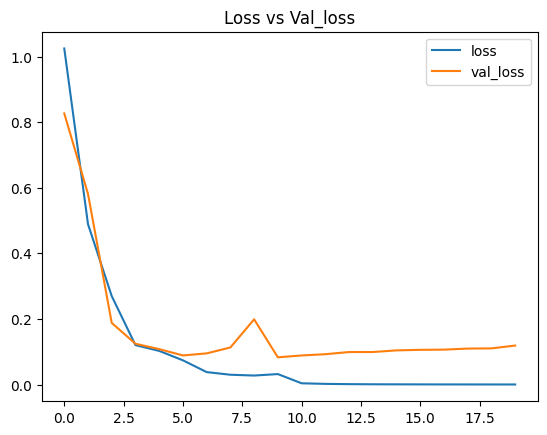

In [29]:
# plot training history
pyplot.plot(LRCN_model_train.history['loss'], label='loss')
pyplot.plot(LRCN_model_train.history['val_loss'], label='val_loss')
pyplot.legend()
plt.title(str('Loss vs Val_loss'))
pyplot.show()

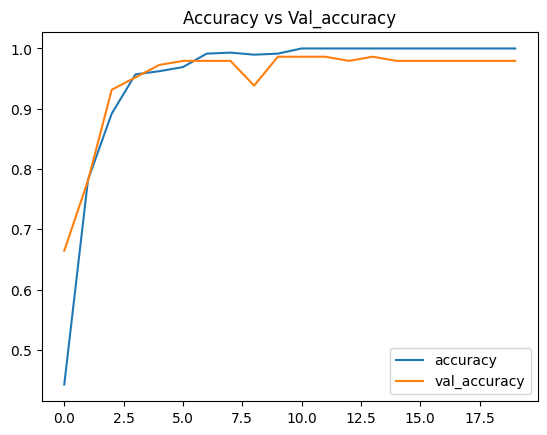

In [30]:
pyplot.plot(LRCN_model_train.history['accuracy'], label='accuracy')
pyplot.plot(LRCN_model_train.history['val_accuracy'], label='val_accuracy')
pyplot.legend()
plt.title(str('Accuracy vs Val_accuracy'))
pyplot.show()

We are saving the model into h5 format to load into real time integration.

In [31]:
accuracy = model_evaluation[1]
model_file_name = f'LRCN_{accuracy}.h5'
print(model_file_name)
LRCN_model.save(model_file_name)

  saving_api.save_model(



LRCN_1.0.h5


We then load the recent LRCN model for the exercise prediction.

In [32]:
from tensorflow.keras.models import load_model
# model_path = '/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/LRCN_0.9012345671653748.h5'
model_path = '/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/LRCN_1.0.h5'
LRCN_model = load_model(model_path)
print(LRCN_model)

Defining the action prediction function
Reference: https://bleedaiacademy.com/human-activity-recognition-using-tensorflow-cnn-lstm/

In [33]:
def action_prediction(video_file_path, frame,model):
    prediction = ''
    frames = []

    capture = cv2.VideoCapture(video_file_path)
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    count_f = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_f = max(int(count_f/frame),1)

    for i in range(frame):
        capture.set(cv2.CAP_PROP_POS_FRAMES, i * skip_f)
        success, frame = capture.read()
        if not success:
            break
        resize_f = cv2.resize(frame, (img_height, img_width))
        norm_f = resize_f / 255
        frames.append(norm_f)

    pred_prob = model.predict(np.expand_dims(frames, axis = 0))[0]
    pred = np.argmax(pred_prob)
    prediction = all_classes[pred]


    capture.release()
    return(prediction,pred_prob[pred])

### **Section 4.2 YOLO**

**Method:** We are using YOLO on the validation dataset. YOLO has proven to be able to provide high accuracy on similar human posture tracking. (https://www.sciencedirect.com/science/article/abs/pii/S0097849323002315?via%3Dihub

**Improvisation:** The reference we are using here is obtained from here: https://dipankarmedh1.medium.com/real-time-object-detection-with-yolo-and-webcam-enhancing-your-computer-vision-skills-861b97c78993

The changes we made is firstly converting this into taking mp4 input rather than webcam. We realize with this method is that the tracker is plotting on non-human object too and this affects the accuracy. We removed the labels list and replaced it with “human” only. We also set the threshold confidence level to be above 0.8 for the bounding box to show up on the videos as we realize having multiple bounding boxes is interfering with accuracy calculation we have.


In [34]:
# Reference : YOLO (https://dipankarmedh1.medium.com/real-time-object-detection-with-yolo-and-webcam-enhancing-your-computer-vision-skills-861b97c78993)

def preprocess_testing_data():
  test_path = '/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/validation/input_validation'
  os.makedirs(test_path, exist_ok=True)
  class_names = os.listdir(test_path)
  for i in class_names:
    video_path = sorted(glob.glob(os.path.join(f'{test_path}/{i}/',"*.mp4")))
    for j in video_path:
      base_name = os.path.basename(j)
      file_name, _ = os.path.splitext(base_name)
      #print(j)
      capture = cv2.VideoCapture(j)

      if not capture.isOpened():
          print("Error: Could not open video.")
          exit()

      fps = int(capture.get(cv2.CAP_PROP_FPS))
      height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
      width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))

      output_path = f'/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/validation/output_validation/{i}/annotated_video_{file_name}.mp4'
      print(output_path)
      os.makedirs(f'/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/validation/output_validation/{i}', exist_ok=True)
      fourcc = cv2.VideoWriter_fourcc(*'mp4v')
      out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

      model = YOLO("yolo-Weights/yolov8n.pt")
      classNames = ["person"]

      results_data = []

      while True:
        success, image = capture.read()
        if not success:
            break

        results = model(image, stream=True)
        f_info = {'frame_id': capture.get(cv2.CAP_PROP_POS_FRAMES), 'bboxes': []}

        for r in results:
          boxes = r.boxes
          for box in boxes:
              x1,y1,x2,y2 = box.xyxy[0]
              x1,y1,x2,y2 = int(x1),int(y1),int(x2),int(y2)
              confidence = math.ceil((box.conf[0]*100))/100
              cls = 0

              bbox_data = {
                  "bbox": [float(x1), float(y1), float(x2-x1), float(y2-y1)],
                  "confidence": confidence,
                  "class_name": classNames[cls]
              }


              f_info['bboxes'].append(bbox_data)
              #  To prevent multiple boxes which interfere with prediction
              if confidence > 0.8:
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 255), 3)

          results_data.append(f_info)
          out.write(image)

      capture.release()
      out.release()
      cv2.destroyAllWindows()


Clear RAM as we always have crashing issue here.

In [57]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

We are plotting the bounding box on the validation videos.

In [ ]:
# import torch
# torch.cuda.empty_cache()


In [35]:
preprocess_testing_data()

Streaming output truncated to the last 5000 lines.
Speed: 2.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape

In [36]:
!pip install tabulate

### **Predicting results for validation set**
In the cell below, we are doing the exercise prediction and plotting them in the table using the tabulate function. We input the 10 videos for each exercise that we allocate in the start of this project, and plot the bounding box using YOLO. We then compare the actual exercise and predicted exercise and count the number of exercise it got correct. (Note that the result is slightly different from the result we show on Friday presentation as we have make small changes to the code)

In [37]:
# height, width = 128, 128
from moviepy.editor import *
from IPython.display import *

from tabulate import tabulate

test_path = '/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/validation/output_validation'
# os.makedirs(test_path, exist_ok = True)
dataset_path = "/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/output"
exercise_types = os.listdir("/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/input/train_test")
# print(exercise_types)
all_classes = exercise_types
# print(all_classes)
classes = os.listdir(test_path)
#print(classes)
result_array = []
total_correct = 0
total_wrong = 0
total_ratio_correct = 0
check = 1
for i in classes:
  video_path = sorted(glob.glob(os.path.join(f'{test_path}/{i}/',"*.mp4")))
  sub_correct = 0
  sub_wrong = 0
  sub_total = 0
  for j in video_path:
    result_sub_array = []
    # print(j)
    # print("i",i)
    base_name = os.path.basename(j)
    # print("base_name",base_name)
    result_sub_array.append(check)
    result_sub_array.append(base_name)
    result_sub_array.append(i)
    predicted_exercise = action_prediction(j, frame,LRCN_model)
    # print("predicted_exercise",predicted_exercise[0])
    result_sub_array.append(predicted_exercise[0])
    last_col =''

    if predicted_exercise[0] == i:
      last_col = 'Correct'
      sub_correct = sub_correct + 1
      total_correct = total_correct + 1
    else:
      last_col = 'Wrong'
      sub_wrong = sub_wrong + 1
      total_wrong =  total_wrong + 1
    result_sub_array.append(predicted_exercise[1])
    result_sub_array.append(last_col)

    check = check + 1
    # print("check",check)
    # print(j)
    result_array.append(result_sub_array)
    if check == 11:
      total_sub_correct = 100*sub_correct/(sub_correct+sub_wrong)
      result_array.append(['','','','','Total percentage correct',total_sub_correct])
      check = 1
    # print(result_sub_array)

    # vid = VideoFileClip(j, audio=False, target_resolution=(300,None)).ipython_display()
    # display(vid)

col_names = ['number','video_number','Real Exercise', 'Predicted Exercise','Confidence Percentage', 'Correct or Wrong' ]
print(tabulate(result_array, headers=col_names, tablefmt="fancy_grid"))
total_ratio_correct = (total_correct / (total_correct + total_wrong))*100
print("total_ratio_correct percentage",total_ratio_correct)


1/1 [==============================] - 0s 23ms/step
╒══════════╤════════════════════════════╤═════════════════╤══════════════════════╤══════════════════════════╤════════════════════╕
│ number   │ video_number               │ Real Exercise   │ Predicted Exercise   │ Confidence Percentage    │ Correct or Wrong   │
╞══════════╪════════════════════════════╪═════════════════╪══════════════════════╪══════════════════════════╪════════════════════╡
│ 1        │ annotated_video_000090.mp4 │ squats          │ squats               │ 0.9143040776252747       │ Correct            │
├──────────┼────────────────────────────┼─────────────────┼──────────────────────┼──────────────────────────┼────────────────────┤
│ 2        │ annotated_video_000091.mp4 │ squats          │ squats               │ 0.6243968605995178       │ Correct            │
├──────────┼────────────────────────────┼─────────────────┼──────────────────────┼──────────────────────────┼────────────────────┤
│ 3        │ annotated_video_00

### **Section 4.3 : 3D CNN**

Here we defined a sequential model with 2 Conv3d layer with relu activation
The Conv3d extracts the features each of these layers are followed by Maxpooling layer for downsampling.
The output from the 2nd maxpooling layer is then flattened and fed into a Fully connected layer with relu and it is then followed by fully connected layer with softmax activation which  gives output probabilities for each class.

In [39]:
img_height = 128
img_width = 128
seq_length = 20
# features, labels, exe_path = [], [], []
train_test_split_params = {
    'test_size': 0.10,
    'shuffle': True,
    'random_state': 0
}
# testsize = 0.1
# train_res, test_res, train_label, test_label = train_test_split(features, onehot_labels, test_size = testsize, shuffle = True, random_state = seed_constant)
# features_train, features_test, labels_train, labels_test = train_test_split(features, onehot_labels, test_size = 0.10, shuffle=True, random_state=seed_constant)
features_train, features_test, labels_train, labels_test = train_test_split(features, onehot_labels, **train_test_split_params)

def cnn3d_model(input_shape):
    model = Sequential([
        Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Conv3D(32, kernel_size=(3, 3, 3), activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(all_classes), activation='softmax')
    ])
    return model


### **3D CNN tuning**

In [40]:

cnn3d = cnn3d_model(input_shape=(seq_length, img_height, img_width, 3))
cnn3d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_params = {
    'monitor': 'val_accuracy',
    'patience': 10,
    'restore_best_weights': True
  }
early_stopping = EarlyStopping(**early_stopping_params)
training_params = {
    'x': features_train,
    'y': labels_train,
    'epochs': 25,
    'validation_data': (features_test, labels_test),
    'callbacks': [early_stopping]
  }



In [41]:
history_3d = cnn3d.fit(**training_params)
epochs_3d = len(history_3d.history['accuracy'])
train_accuracy_3d = history_3d.history['accuracy']
val_accuracy_3d = history_3d.history['val_accuracy']

model_evaluation_history_cnn3d = cnn3d.evaluate(features_test, labels_test)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history_cnn3d


model_file_name_cnn3d = f'cnn3d{model_evaluation_accuracy}.h5'
print(model_file_name_cnn3d)

cnn3d.save(model_file_name_cnn3d)


Epoch 1/25
23/23 [==============================] - 11s 357ms/step - loss: 1.4696 - accuracy: 0.5295 - val_loss: 0.5845 - val_accuracy: 0.7531
Epoch 2/25
23/23 [==============================] - 5s 235ms/step - loss: 0.3242 - accuracy: 0.8697 - val_loss: 0.1972 - val_accuracy: 0.9506
Epoch 3/25
23/23 [==============================] - 5s 234ms/step - loss: 0.1017 - accuracy: 0.9602 - val_loss: 0.2197 - val_accuracy: 0.9012
Epoch 4/25
23/23 [==============================] - 5s 236ms/step - loss: 0.0535 - accuracy: 0.9877 - val_loss: 0.1364 - val_accuracy: 0.9383
Epoch 5/25
23/23 [==============================] - 5s 237ms/step - loss: 0.0234 - accuracy: 0.9959 - val_loss: 0.1045 - val_accuracy: 0.9506
Epoch 6/25
23/23 [==============================] - 5s 238ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9630
Epoch 7/25
23/23 [==============================] - 5s 234ms/step - loss: 0.0070 - accuracy: 0.9973 - val_loss: 0.2755 - val_accuracy: 0.9136
Epoch

  saving_api.save_model(



cnn3d1.0.h5


In [42]:
print(model_evaluation_loss, model_evaluation_accuracy)

0.021856795996427536 1.0


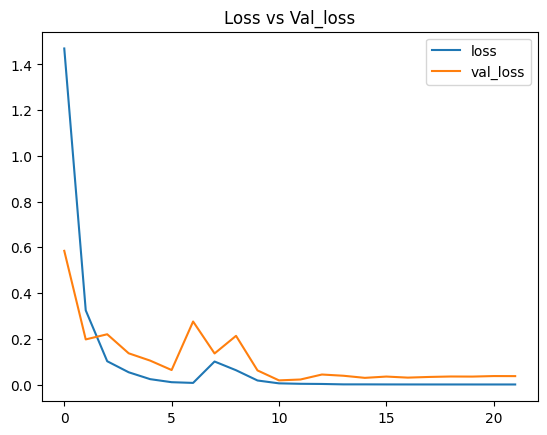

In [43]:
# plot training history
# model_evaluation = LRCN_model.evaluate(test_res, test_label)
pyplot.plot(history_3d.history['loss'], label='loss')
pyplot.plot(history_3d.history['val_loss'], label='val_loss')
pyplot.legend()
plt.title(str('Loss vs Val_loss'))
pyplot.show()

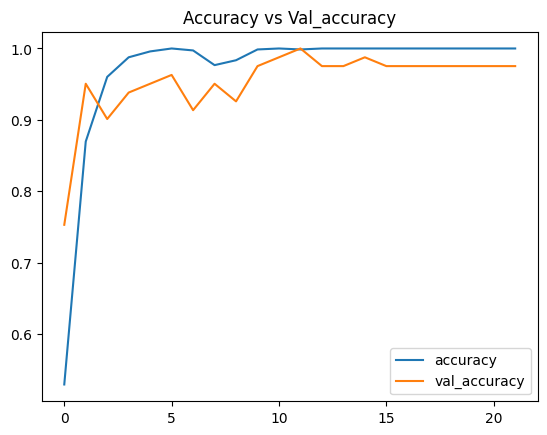

In [44]:
pyplot.plot(history_3d.history['accuracy'], label='accuracy')
pyplot.plot(history_3d.history['val_accuracy'], label='val_accuracy')
pyplot.legend()
plt.title(str('Accuracy vs Val_accuracy'))
pyplot.show()

### **Predicting results for validation set for 3D CNN**

In [45]:
# height, width = 128, 128

from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/cnn3d1.0.h5'
# model_path = '/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/LRCN_0.9259259104728699.h5'
cnn3d_model = load_model(model_path)
print(cnn3d_model)

from moviepy.editor import *
from IPython.display import *

from tabulate import tabulate

test_path = '/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/validation/output_validation'
# os.makedirs(test_path, exist_ok = True)
dataset_path = "/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/output"
exercise_types = os.listdir("/content/drive/MyDrive/COMP9444_TEST/Trial_JSON/input/train_test")
print(exercise_types)
all_classes = exercise_types
print(all_classes)
classes = os.listdir(test_path)
#print(classes)
result_array = []
total_correct = 0
total_wrong = 0
total_ratio_correct = 0
check = 1
for i in classes:
  video_path = sorted(glob.glob(os.path.join(f'{test_path}/{i}/',"*.mp4")))
  sub_correct = 0
  sub_wrong = 0
  sub_total = 0
  for j in video_path:
    result_sub_array = []
    # print(j)
    # print("i",i)
    base_name = os.path.basename(j)
    # print("base_name",base_name)
    result_sub_array.append(check)
    result_sub_array.append(base_name)
    result_sub_array.append(i)
    predicted_exercise = action_prediction(j, frame,cnn3d_model)
    # print("predicted_exercise",predicted_exercise[0])
    result_sub_array.append(predicted_exercise[0])
    last_col =''

    if predicted_exercise[0] == i:
      last_col = 'Correct'
      sub_correct = sub_correct + 1
      total_correct = total_correct + 1
    else:
      last_col = 'Wrong'
      sub_wrong = sub_wrong + 1
      total_wrong =  total_wrong + 1
    result_sub_array.append(predicted_exercise[1])
    result_sub_array.append(last_col)

    check = check + 1
    # print("check",check)
    # print(j)
    result_array.append(result_sub_array)
    if check == 11:
      total_sub_correct = 100*sub_correct/(sub_correct+sub_wrong)
      result_array.append(['','','','','Total percentage correct',total_sub_correct])
      check = 1
    print(result_sub_array)

    # vid = VideoFileClip(j, audio=False, target_resolution=(300,None)).ipython_display()
    # display(vid)

col_names = ['number','video_number','Real Exercise', 'Predicted Exercise','Confidence Percentage', 'Correct or Wrong' ]
print(tabulate(result_array, headers=col_names, tablefmt="fancy_grid"))
total_ratio_correct = (total_correct / (total_correct + total_wrong))*100
print("total_ratio_correct percentage",total_ratio_correct)


['squats', 'curls', 'overheadpress']
['squats', 'curls', 'overheadpress']
1/1 [==============================] - 0s 134ms/step
[1, 'annotated_video_000090.mp4', 'squats', 'squats', 0.9617587, 'Correct']
1/1 [==============================] - 0s 20ms/step
[2, 'annotated_video_000091.mp4', 'squats', 'overheadpress', 0.9144107, 'Wrong']
1/1 [==============================] - 0s 21ms/step
[3, 'annotated_video_000092.mp4', 'squats', 'overheadpress', 0.52291876, 'Wrong']
1/1 [==============================] - 0s 20ms/step
[4, 'annotated_video_000093.mp4', 'squats', 'squats', 0.9977816, 'Correct']
1/1 [==============================] - 0s 24ms/step
[5, 'annotated_video_000094.mp4', 'squats', 'overheadpress', 0.80615145, 'Wrong']
1/1 [==============================] - 0s 21ms/step
[6, 'annotated_video_000095.mp4', 'squats', 'squats', 0.955618, 'Correct']
1/1 [==============================] - 0s 22ms/step
[7, 'annotated_video_000096.mp4', 'squats', 'squats', 0.9803243, 'Correct']
1/1 [========

### **Section 5: Summary of result and discussion**
Based on the result we have; 3D CNN gives better accuracy when classifying the exercise.3D CNN has proven its capability in classifying the squats and overhead press correctly. Both the models have issue predicting curls correctly.

If comparing with relevant papers in similar project(https://ieeexplore.ieee.org/document/9888451), their prediction accuracy is much higher than what we get. This is because of their quality of dataset. The graph we are having is also showing an unstable convergence trend. We believe this is because of the angle of how our video is taken.

The strength of our model lies in its ability to be input to real time exercise prediction and able to do proper exercise prediction. However due to the latency issue, there is a delay when the tracker is counting the number of repetitions, hence confusing the user with the counter function. The other issues we are having is due to the RAM issues hence limiting our initial project intention which is to classify all 10 exercises we have.

In future, we are planning to include more exercises for prediction and incorporate functions to remind the user on to correct his posture when doing the exercise.
